# Malaria Detection Project

In this Notebook a Deep Learning Classifier is trained to recognice if an blood cell is infected with Malaria or not.
To that purpose a Sequential Model is setup and trained based on the work of [LS. Rajaraman et al.](https://peerj.com/articles/4568/?ref=https%3A%2F%2Fgithubhelp.com&utm_source=TrendMD&utm_campaign=PeerJ_TrendMD_1&utm_medium=TrendMD)

In [1]:
import io
import os
import random
import datetime
from typing import Tuple, Optional

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

import sklearn
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns

from google.colab import drive, files
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Layer,
    Conv2D,
    MaxPool2D,
    Dense,
    Flatten,
    InputLayer,
    BatchNormalization,
    Input,
    Dropout,
    RandomFlip,
    RandomRotation,
    Resizing,
    Rescaling,
)
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import (
    BinaryAccuracy,
    FalsePositives,
    FalseNegatives,
    TruePositives,
    TrueNegatives,
    Precision,
    Recall,
    AUC,
    binary_accuracy,
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    Callback,
    CSVLogger,
    EarlyStopping,
    LearningRateScheduler,
    ModelCheckpoint,
    ReduceLROnPlateau,
)
from tensorflow.keras.regularizers import L2, L1
from tensorboard.plugins.hparams import api as hp

# **Define Functions**

In [2]:
def split_dataset(dataset: tf.data.Dataset,
                  train_ratio: float,
                  val_ratio: float,
                  test_ratio: float) -> Tuple[tf.data.Dataset,
                                              tf.data.Dataset,
                                              tf.data.Dataset]:
    """
    Split a dataset into training, validation, and test sets.

    Args:
        dataset (tf.data.Dataset): The input dataset to be split.
        train_ratio (float): The ratio of data to be used for training.
        val_ratio (float): The ratio of data to be used for validation.
        test_ratio (float): The ratio of data to be used for testing.

    Returns:
        tuple: A tuple containing the training, validation, and test datasets.
    """
    # Define the size of the dataset
    dataset_size = len(dataset)
    # Grab the training set
    train_dataset = dataset.take(int(train_ratio * dataset_size))
    # Define the part of the dataset without the training set
    rest_of_dataset = dataset.skip(int(train_ratio * dataset_size))
    # Split the rest of the dataset into validation and test sets
    val_dataset = rest_of_dataset.take(int(val_ratio * dataset_size))
    test_dataset = rest_of_dataset.skip(int(val_ratio * dataset_size))

    return train_dataset, val_dataset, test_dataset


def plot_dataset_images_with_labels(train_dataset: tf.data.Dataset,
                                    amount_of_pictures: int,
                                    dataset_info: tfds.core.DatasetInfo,
                                    subplot_rows: int,
                                    subplot_columns: int):
    """
    Plot tf.data.dataset images with their corresponding labels.

    Args:
        train_dataset (tf.data.Dataset): The dataset containing images and labels.
        amount_of_pictures (int): The number of pictures to plot.
        dataset_info (tfds.core.DatasetInfo): Information about the dataset.
        subplot_rows (int): The number of subplot rows.
        subplot_columns (int): The number of subplot columns.

    Returns:
        None: This function does not return a value, or it returns None.
    """
    # Adjust the spacing between subplots
    plt.subplots_adjust(hspace=0.5)

    for i, (image, label) in enumerate(train_dataset.take(amount_of_pictures)):
        ax = plt.subplot(subplot_rows, subplot_columns, i + 1)
        plt.imshow(image)
        plt.title(dataset_info.features['label'].int2str(label))
        plt.axis('off')

    plt.show()

# **Data Loading**

In [3]:
# Load the data from the malaria detection dataset.
dataset, dataset_info = tfds.load('malaria', with_info=True,
                                  as_supervised=True,
                                  shuffle_files = True,
                                  split=['train'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteGS10OV/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [4]:
#Define the splitting ratios of the dataset
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1
# Split the dataset into train-, validation- and test-set.
train_dataset, val_dataset, test_dataset = split_dataset(dataset[0],
                                                         TRAIN_RATIO,
                                                         VAL_RATIO,
                                                         TEST_RATIO)

In [5]:
train_dataset

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [6]:
val_dataset

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

# **Dataset Visualization**

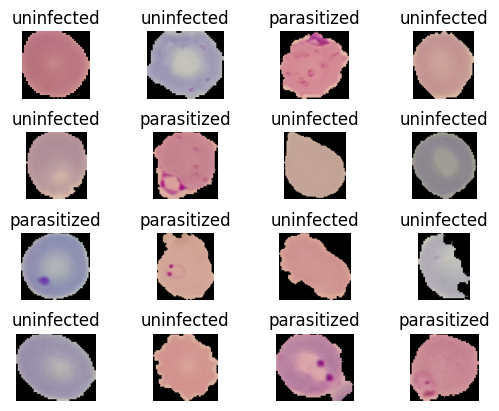

In [7]:
# Plot dataset images
plot_dataset_images_with_labels(train_dataset, 16, dataset_info, 4, 4)

# **Data Augmentation**

In [8]:
def resize_rescale(image: Tensor, label: Tensor) -> Tuple[Tensor, Tensor]:
    """
    Resize and rescale an image.

    Args:
        image (Tensor): The input image tensor.
        label (Tensor): The label associated with the image.

    Returns:
        Tuple[Tensor, Tensor]: A tuple containing the resized and rescaled image tensor
        and the original label tensor.

    This function resizes the input image to (224, 224) and rescales it by dividing by 255.0.
    """
    resized_image = tf.image.resize(image, (224, 224)) / 255.0
    return resized_image, label

In [9]:
# Normalize the size of the images
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)

In [10]:
train_dataset

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [11]:
val_dataset

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

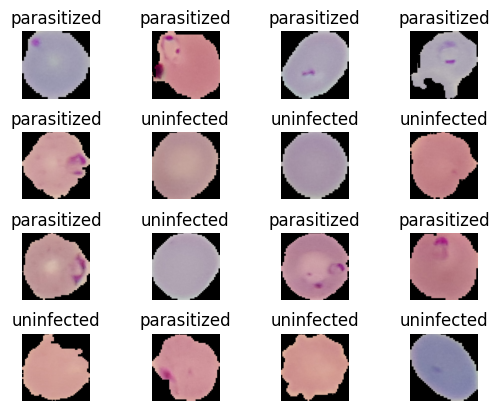

In [12]:
# Plot dataset images and check the homogenous image size
plot_dataset_images_with_labels(train_dataset, 16, dataset_info, 4, 4)

In [13]:
train_dataset = (
    # Assign the variable 'train_dataset'
    train_dataset  
    # Shuffle the dataset with a buffer size of 8 and reshuffle it at each iteration.
    .shuffle(buffer_size = 8, reshuffle_each_iteration = True)  
    # Group the elements into batches, with each batch containing 32 elements.
    .batch(32)  
    # Prefetch data with an optimization parameter for more efficient processing during training.
    .prefetch(tf.data.AUTOTUNE)  
)

val_dataset = (
    # Assign the variable 'train_dataset'
    val_dataset
    # Shuffle the dataset with a buffer size of 8 and reshuffle it at each iteration.
    .shuffle(buffer_size = 8, reshuffle_each_iteration = True)
    # Group the elements into batches, with each batch containing 32 elements.
    .batch(32)
    # Prefetch data with an optimization parameter for more efficient processing during training.
    .prefetch(tf.data.AUTOTUNE)
)

In [14]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [15]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

# **Sequential Model**

In [16]:
# Setup the sequential model
model = tf.keras.Sequential([
    InputLayer(input_shape=(224,224,3)),

    Conv2D(filters = 6, kernel_size = 3, strides = 1,
           padding = 'valid', activation = 'relu'),
    BatchNormalization(),

    MaxPool2D(pool_size = 2, strides = 2),

    Conv2D(filters = 6, kernel_size = 3, strides = 1,
           padding = 'valid', activation = 'relu'),
    BatchNormalization(),

    MaxPool2D(pool_size = 2, strides = 2),

    Flatten(),

    Dense(100, activation='relu'),
    BatchNormalization(),

    Dense(10, activation='relu'),
    BatchNormalization(),

    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 6)       330       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 6)       24        
 chNormalization)                                                
                                                        

In [17]:
# Create a list of different metrics to evaluate the model's performance.
# The metrics include True Positives, False Positives, True Negatives, False Negatives, Binary Accuracy, Precision, Recall, and AUC.
metrics = [
    TruePositives(name='tp'),
    FalsePositives(name='fp'),
    TrueNegatives(name='tn'),
    FalseNegatives(name='fn'),
    BinaryAccuracy(name='accuracy'),
    Precision(name='precision'),
    Recall(name='recall'),
    AUC(name='auc')
]

# Compile the machine learning model with the following configurations:
# - Optimizer: Adam with a learning rate of 0.1
# - Loss function: Binary Crossentropy (commonly used for binary classification problems)
# - Evaluation metrics: The list of metrics defined above will be used to assess the model's performance.
model.compile(
    optimizer=Adam(learning_rate=0.1),
    loss=BinaryCrossentropy(),
    metrics=metrics
)

In [18]:
# Train the machine learning model
history = model.fit(
    # Set training dataset
    train_dataset, 
    # Set validation dataset
    validation_data=val_dataset, 
    # Define the number of training epochs
    epochs=100, 
    # Set the verbosity level during training
    verbose=2                  
)

Epoch 1/100
689/689 - 28s - loss: 0.5676 - tp: 8151.0000 - fp: 3538.0000 - tn: 7478.0000 - fn: 2879.0000 - accuracy: 0.7089 - precision: 0.6973 - recall: 0.7390 - auc: 0.7810 - val_loss: 5.2561 - val_tp: 138.0000 - val_fp: 209.0000 - val_tn: 1155.0000 - val_fn: 1253.0000 - val_accuracy: 0.4693 - val_precision: 0.3977 - val_recall: 0.0992 - val_auc: 0.4204 - 28s/epoch - 41ms/step
Epoch 2/100
689/689 - 13s - loss: 0.2992 - tp: 10520.0000 - fp: 1620.0000 - tn: 9403.0000 - fn: 503.0000 - accuracy: 0.9037 - precision: 0.8666 - recall: 0.9544 - auc: 0.9373 - val_loss: 0.8483 - val_tp: 1211.0000 - val_fp: 305.0000 - val_tn: 1068.0000 - val_fn: 171.0000 - val_accuracy: 0.8272 - val_precision: 0.7988 - val_recall: 0.8763 - val_auc: 0.8941 - 13s/epoch - 18ms/step
Epoch 3/100
689/689 - 13s - loss: 0.2676 - tp: 10461.0000 - fp: 1347.0000 - tn: 9676.0000 - fn: 562.0000 - accuracy: 0.9134 - precision: 0.8859 - recall: 0.9490 - auc: 0.9494 - val_loss: 0.3090 - val_tp: 1350.0000 - val_fp: 251.0000 - v

# **Defining an custom Model**

In [ ]:
class NeuralearnDense(Layer):
    def __init__(self, output_units: int, activation: str):
        """
        Initialize the NeuralearnDense layer.

        Args:
            output_units (int): The number of output units in the layer.
            activation (str): The activation function to use ("relu" or "sigmoid").
        """
        super(NeuralearnDense, self).__init__()
        self.output_units = output_units
        self.activation = activation

    def build(self, input_features_shape: Tuple[int]):
        """
        Build the layer by adding weight variables.

        Args:
            input_features_shape (Tuple[int]): The shape of the input features.
        """
        self.w = self.add_weight(shape=(input_features_shape[-1], self.output_units),
                                initializer="random_normal",
                                trainable=True)
        self.b = self.add_weight(shape=(self.output_units,),
                                initializer="random_normal",
                                trainable=True)

    def call(self, input_features: Tensor) -> Tensor:
        """
        Perform the forward pass of the NeuralearnDense layer.

        Args:
            input_features (Tensor): The input features.

        Returns:
            Tensor: The output of the layer after applying activation.
        """
        pre_output = tf.matmul(input_features, self.w) + self.b

        if self.activation == "relu":
            return tf.nn.relu(pre_output)
        elif self.activation == "sigmoid":
            return tf.math.sigmoid(pre_output)
        else:
            return pre_output

In [ ]:
# Setup the sequential model using the custom defined NeuralearnDense layer 
custom_model = tf.keras.Sequential([
    InputLayer(input_shape = (224, 224, 3)),

    Conv2D(filters = 6, kernel_size = 3, strides=1, 
           padding='valid', activation = 'relu'),
    
    BatchNormalization(),
    MaxPool2D (pool_size = 2, strides= 2),

    Conv2D(filters = 16, kernel_size = 3, strides=1, 
           padding='valid', activation = 'relu'),
    BatchNormalization(),
    MaxPool2D (pool_size = 2, strides= 2),

    Flatten(),

    NeuralearnDense(100, activation = "relu"),
    BatchNormalization(),

    NeuralearnDense(10, activation = "relu"),
    BatchNormalization(),
    
    NeuralearnDense(1, activation = "sigmoid"),
])
custom_model.summary()

# **Visualizing Confusion Matrix**

In [19]:
# Preparing the testing data for predictions
labels = []
inp = []
for x,y in test_dataset.as_numpy_iterator():
  labels.append(y)
  inp.append(x)

In [20]:
print(np.array(inp).shape)
print(len(labels))

(2757, 224, 224, 3)
2757


In [22]:
# Make a prediction on the testing data using the trained model
predicted = model.predict(np.array(inp))

87/87 [==============================] - 1s 8ms/step


[[1277  113]
 [  66 1301]]


Text(0.5, 58.7222222222222, 'Predicted')

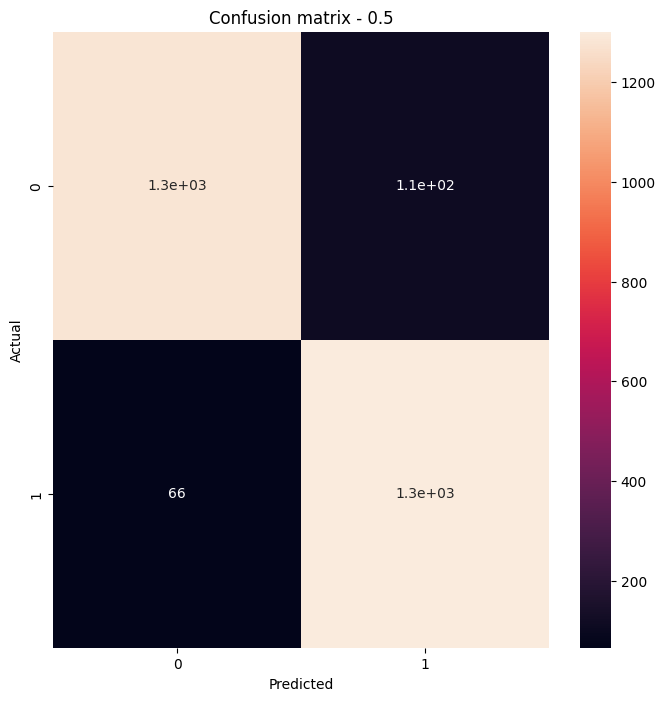

In [24]:
# Set the threshold for binary classification (values above threshold are considered positive)
threshold = 0.5

# Compute the confusion matrix based on actual labels and predicted values above the threshold
cm = confusion_matrix(labels, predicted > threshold)

# Print the confusion matrix to the console
print(cm)

# Create a new figure with a specified size for the heatmap
plt.figure(figsize=(8, 8))

# Create a heatmap to visualize the confusion matrix, with annotations (numbers) in each cell
sns.heatmap(cm, annot=True)

# Set the title of the heatmap, incorporating the chosen threshold value
plt.title(f'Confusion matrix - {threshold}')

# Set the label for the vertical axis
plt.ylabel('Actual')

# Set the label for the horizontal axis
plt.xlabel('Predicted')

One can see that a threshold at 50% results in 66 false negatives and 113 false positives. To optimice the threshold 
a ROC plot is created

# **ROC Plots**

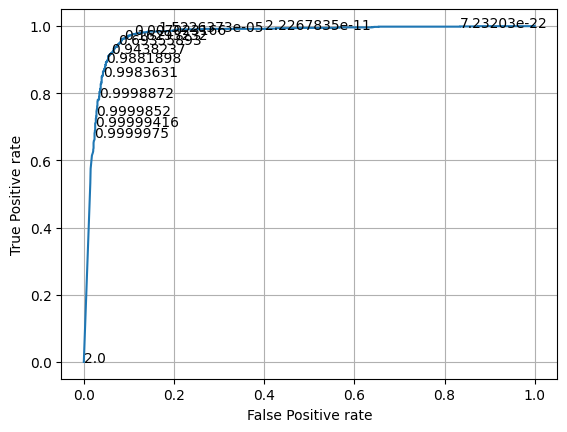

In [25]:
# Compute the False Positive rate (fp), True Positive rate (tp), 
# and associated thresholds for the ROC curve
fp, tp, thresholds = roc_curve(labels, predicted)

# Plot the ROC curve using False Positive rate (x-axis) and True Positive rate (y-axis)
plt.plot(fp, tp)

# Set the label for the x-axis
plt.xlabel("False Positive rate")

# Set the label for the y-axis
plt.ylabel("True Positive rate")

# Add a grid to the plot for better visualization
plt.grid()

# Define the skip value to control how many threshold values are labeled on the ROC curve
skip = 20

# Loop through the thresholds and label some of them on the ROC curve
for i in range(0, len(thresholds), skip):
    # Add the thresholds at the corresponding point on the ROC curve
    plt.text(fp[i], tp[i], thresholds[i])

# Display the ROC curve plot
plt.show()

Based on this plot a better choise for the threshold lies between 94% - 85%

# Visual Illustration of Prediction

In [26]:
def parasite_or_not(x: float) -> str:
    """
    Determine if a value is classified as 'Parasite' (P) or 'Uninfected' (U).

    Args:
        x (float): A value between 0 and 1.

    Returns:
        str: 'P' if the input value is less than 0.5, 'U' otherwise.
    """
    if x < 0.5:
        return 'P'
    else:
        return 'U'


1/1 [==============================] - 0s 23ms/step
[[0.99198556]] [1]
1/1 [==============================] - 0s 20ms/step
[[8.462413e-17]] [0]
1/1 [==============================] - 0s 20ms/step
[[9.120585e-21]] [0]
1/1 [==============================] - 0s 21ms/step
[[1.]] [1]
1/1 [==============================] - 0s 21ms/step
[[8.935177e-09]] [0]
1/1 [==============================] - 0s 21ms/step
[[0.99994993]] [1]
1/1 [==============================] - 0s 21ms/step
[[6.0374323e-06]] [0]
1/1 [==============================] - 0s 22ms/step
[[1.]] [1]
1/1 [==============================] - 0s 21ms/step
[[1.2975749e-13]] [0]


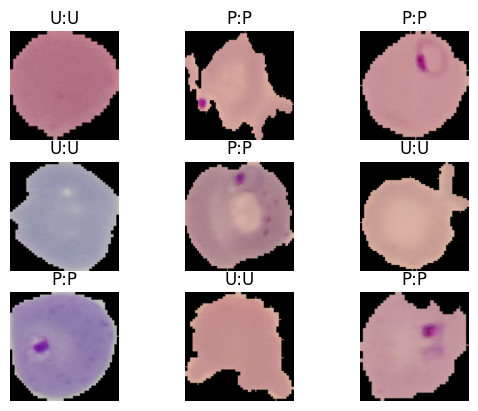

In [38]:
# Loop through the first 9 batches of the test dataset, each containing a single image and label
for i, (image, label) in enumerate(test_dataset.batch(1).take(9)):

    # Create a subplot with a 3x3 grid, and set the current subplot to the i-th position
    ax = plt.subplot(3, 3, i + 1)

    # Display the image contained in the batch
    plt.imshow(image[0])

    # Extract the numeric label value from the TensorFlow tensor
    label_value = label.numpy()

    # Use the model to make predictions on the image
    prediction_value = model.predict(image)

    # Print the predicted value and the actual label value
    print(prediction_value, label_value)

    # Set the subplot's title, indicating whether it's 'Parasite' (P) or 
    # 'Uninfected' (U) for both actual and predicted labels
    plt.title(f"{parasite_or_not(label_value)}:{parasite_or_not(prediction_value)}")

    # Turn off the axis for better visualization
    plt.axis('off')

# **Saving the Model**

In [ ]:
model.save("model")

In [ ]:
model.save("model.hdf5")

In [ ]:
model.save_weights("weights/weights")